In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
import time
import matplotlib.ticker as tkr
from scipy import stats
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
from sklearn.preprocessing import MinMaxScaler
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras import optimizers

%matplotlib inline

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv
Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv


In [ ]:
#read dataframe from DB
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True)

df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']

df = df.dropna()

In [ ]:
df = df.reset_index(level=0)

In [ ]:
df["Date Time"] = pd.to_datetime(df['datetime'])

In [ ]:
df["Day"] = df["Date Time"].dt.day
df["Month"] = df["Date Time"].dt.month
df["Year"] = df["Date Time"].dt.year
df["Hour"] = df["Date Time"].dt.hour
df["Minute"] = df["Date Time"].dt.minute
df["Demand"] = pd.to_numeric(df['Price - PT [€/MWh]'], errors = 'coerce')

In [ ]:
df

,datetime,Price - PT [€/MWh],Price - ES [€/MWh],Actual Consumption (MWh),Biomass AA,Fossil Gas AA,Fossil Hard Coal AC,Hydro Pumped Storage AA,Hydro Pumped Storage AC,Hydro Run-of-river and poundage AA,...,Wind Onshore AA,Electricity Consumption (MWh),Season,Date Time,Day,Month,Year,Hour,Minute,Demand
0,2017-01-01 01:00:00,58.82,58.82,5302,355.00,1654,0,168,5,335,...,325,5302,1,2017-01-01 01:00:00,1,1,2017,1,0,58.82
1,2017-01-01 02:00:00,58.23,58.23,5077,358.00,999,0,157,6,218,...,374,5077,1,2017-01-01 02:00:00,1,1,2017,2,0,58.23
2,2017-01-01 03:00:00,51.95,51.95,4875,358.00,805,0,101,60,248,...,420,4875,1,2017-01-01 03:00:00,1,1,2017,3,0,51.95
3,2017-01-01 04:00:00,47.27,47.27,4561,352.00,668,0,100,33,184,...,433,4561,1,2017-01-01 04:00:00,1,1,2017,4,0,47.27
4,2017-01-01 05:00:00,46.90,45.49,4271,357.00,357,0,0,663,190,...,450,4271,1,2017-01-01 05:00:00,1,1,2017,5,0,46.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45594,2022-03-15 19:00:00,277.80,277.80,5434,400.00,1623,0,117,228,1162,...,756,5434,2,2022-03-15 19:00:00,15,3,2022,19,0,277.80
45595,2022-03-15 20:00:00,297.01,297.01,5977,403.00,1594,0,918,4,1707,...,907,5977,2,2022-03-15 20:00:00,15,3,2022,20,0,297.01
45596,2022-03-15 21:00:00,311.71,311.71,6144,406.00,1579,0,1544,1,2012,...,1012,6144,2,2022-03-15 21:00:00,15,3,2022,21,0,311.71
45597,2022-03-15 22:00:00,304.19,304.19,6207,402.00,1587,0,1332,1,2003,...,1261,6207,2,2022-03-15 22:00:00,15,3,2022,22,0,304.19


In [ ]:
columns = ['datetime','Date Time', 'Price - PT [€/MWh]', 'Price - ES [€/MWh]','Actual Consumption (MWh)', 'Biomass AA', 'Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)']
for column in columns :
  df.drop([column],  axis=1, inplace=True )

In [ ]:
X= []
y= []

In [ ]:
for i in range(0, df.shape[0]-14):
    X.append(df.iloc[i:i+14,5])
    y.append(df.iloc[i+14,5])
    
X, y = np.array(X), np.array(y)
y = np.reshape(y, (len(y), 1))

In [ ]:
pd.DataFrame(X).to_csv('appended_Demand.csv')
pd.DataFrame(y).to_csv('appended_Demand_1.csv')

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [ ]:
#split
size = int(len(df)*0.8)
           
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath ='models/MODEL.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',patience=50),
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

optimizers.Adam(lr=0.0001)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
start_time = time.time()

history = model.fit(X_train, y_train, validation_split=0.33, epochs=1000, callbacks=callbacks, batch_size=20)

exec_time = time.time()-start_time

Epoch 1/1000
1222/1222 [==============================] - 15s 7ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/1000
1222/1222 [==============================] - 7s 6ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 3/1000
1222/1222 [==============================] - 8s 7ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 4/1000
1222/1222 [==============================] - 8s 7ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 5/1000
1222/1222 [==============================] - 8s 7ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 6/1000
1222/1222 [==============================] - 9s 7ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 7/1000
1222/1222 [==============================] - 7s 6ms/step - loss: 0.0000e+0

In [ ]:
model.load_weights("models/MODEL.hdf5")

In [ ]:
yhat = model.predict(X_test)

In [ ]:
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y_test)

In [ ]:
from sklearn import metrics
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
Coefficient of Variance: nan
R2: 1.0
exec_time: 416.3168132305145


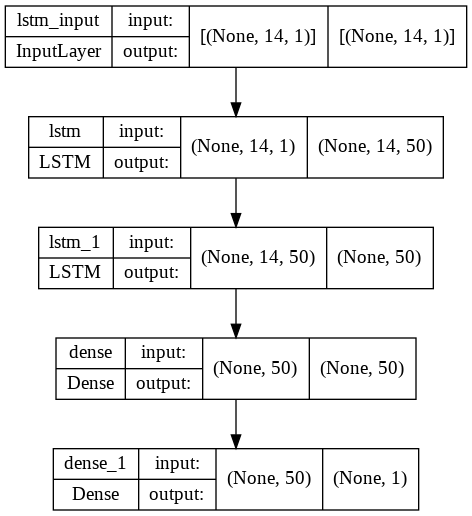

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True )

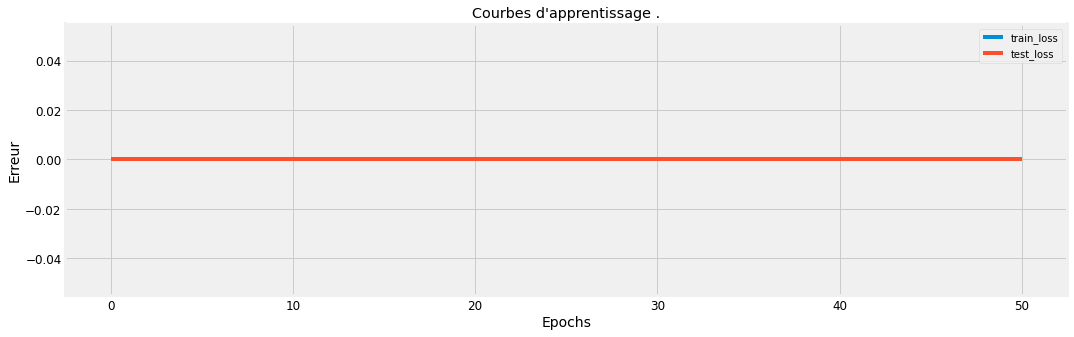

In [ ]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [ ]:
import time

for i in range(0, X_test.shape[0]):
    demand_summary = []
    X_input = X_test[i,:,:]
    X_input = np.reshape(X_input, (1, X_input.shape[0], 1))
    X_input = model.predict(X_input)
    forecast = scaler.inverse_transform(X_input)
    
    
    y_input = y_test[i,:]
    y_input = np.reshape(y_input, (1,1))
    actual = scaler.inverse_transform(y_input)
    
    demand_summary.append(actual)
    demand_summary.extend(forecast)
    
    df_animate = pd.DataFrame(demand_summary)
    df_animate = df_animate.T
    df_animate.to_csv('real time demand.csv', mode='a', header=False, index=False)
    
    print(demand_summary)
    time.sleep(4)